# **MNIST CONV**

Hi, welcome to this PyTorch implementation of ConvNet to classify the well-khown MNIST dataset from scratch. Remember that in Colab you can set your notebook to use GPU rather than CPU by 

```
Edit -> Notebook Settings -> Hardware accelerator -> GPU
```
You might not need this for this particular implementation since it's fairly simple, but it will be very useful later on when your model gets more complex.

Let's dive in! Have fun!

In [0]:
########## Import ############
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [0]:
#### Load the MNIST dataset #####
train_data = datasets.MNIST('~/data/mnist/', train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST('~/data/mnist/', train=False, transform=transforms.ToTensor(), download=True)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=128, 
            shuffle=True, num_workers=4, drop_last=True)

The following function is to view the samples from the training set

In [0]:
def view_samples(samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

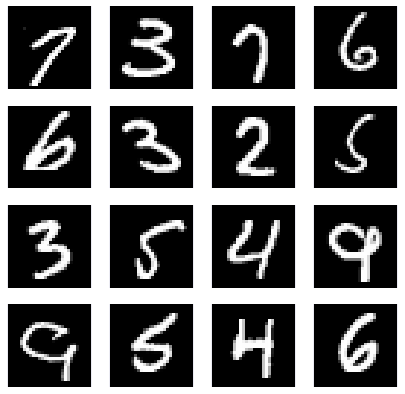

In [46]:
############### Viewing 16 random images from MNIST training set #############
ind = np.random.choice(len(train_data), 16)
samples = []
for i in ind:
  samples.append(train_data[i][0].numpy())
_ = view_samples(np.array(samples).transpose(0,2,3,1))

Here comes the important part: the Model. As you can see this model has the following structure:

```
Input -> Conv(3x3x16,1) -> Relu -> Max pool(2x2,2) -> Conv(3x3x8,1) -> Relu -> Max pool(2x2,2) -> Conv(3x3x8,1) -> Relu -> Max pool(2x2,2) -> FC -> Sigmoid
```
where <code>Conv(3x3x16,1)</code> means the spatial resolution of the filter is <code>3x3</code>, <code>16</code> filters and the stride is <code>1</code>. Similar notation applies to <code>Max pool</code> as well.


In [0]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(16, 8, 3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(8, 8, 3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(2, padding=0)
    self.pool2 = nn.MaxPool2d(2, padding=1)
    self.fc = nn.Linear(128, 10, bias=False)
  def forward(self, image):
    conv1 = self.conv1(image)
    relu1 = F.relu(conv1) #28x28x16
    pool1 = self.pool1(relu1) #14x14x16
    conv2 = self.conv2(pool1) #14x14x8
    relu2 = F.relu(conv2)
    pool2 = self.pool1(relu2) #7x7x8
    conv3 = self.conv3(pool2) #7x7x8
    relu3 = F.relu(conv3)
    pool3 = self.pool2(relu3) #4x4x8
    pool3 = pool3.view([image.size(0), 8*4*4]).cuda() ##### Flatten this layer
    fc = self.fc(pool3)
    logits = F.sigmoid(fc)
    return logits

Then I initialize the model, loss, optimizer and scheduler for the learning rate. The loss I'm using is Cross Entropy Loss. Different loss functions can be found [here](http://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html). I'm using Stochastic Gradient Descent for the optimizer. Lastly, the scheduler means reducing the learning rate by the factor of <code>10</code> every <code>7</code> epochs.

In [0]:
model = Model()
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


This is the final step: Training! I train the model for 15 epochs 

In [0]:
def train(model, criterion, optimizer, scheduler, data_loader):
  epochs = 15
  for epoch in range(epochs): 
    print('Epoch {}\{}'.format(epoch,epochs-1))
    tot_loss = 0.0
    correct = 0
    scheduler.step()
    for data in data_loader:
      inputs, labels = data
      inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
      optimizer.zero_grad()
      logits = model(inputs)
      _, preds = torch.max(logits.data,1)
      loss = criterion(logits, labels)
      loss.backward()
      optimizer.step()
      tot_loss += loss.data[0]
      correct += torch.sum(preds == labels.data)
    print('Epoch loss: ', tot_loss/len(train_data))
    print('Epoch acc: ', correct/len(train_data))
  return model
    
    

In [66]:
model = train(model, criterion, optimizer, scheduler, data_loader)

Epoch 0\14
Epoch loss:  0.012440653942028682
Epoch acc:  0.8590666666666666
Epoch 1\14
Epoch loss:  0.01236017829577128
Epoch acc:  0.8744333333333333
Epoch 2\14
Epoch loss:  0.011901360255479812
Epoch acc:  0.9376833333333333
Epoch 3\14
Epoch loss:  0.011701269006729126
Epoch acc:  0.9599333333333333
Epoch 4\14
Epoch loss:  0.011669639150301616
Epoch acc:  0.9636
Epoch 5\14
Epoch loss:  0.011643272747596104
Epoch acc:  0.9673166666666667
Epoch 6\14
Epoch loss:  0.011593472143014273
Epoch acc:  0.9722666666666666
Epoch 7\14
Epoch loss:  0.011580984232823053
Epoch acc:  0.9738166666666667
Epoch 8\14
Epoch loss:  0.011576010372241338
Epoch acc:  0.9749833333333333
Epoch 9\14
Epoch loss:  0.011571064539750417
Epoch acc:  0.9750833333333333
Epoch 10\14
Epoch loss:  0.011569445023934047
Epoch acc:  0.9755833333333334
Epoch 11\14
Epoch loss:  0.011566572250922521
Epoch acc:  0.9758166666666667
Epoch 12\14
Epoch loss:  0.011565895901123682
Epoch acc:  0.9759833333333333
Epoch 13\14
Epoch loss

Finally test the model on the test set.

In [69]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, 
            shuffle=True, num_workers=4, drop_last=True)
correct = 0
model.train(False)
for data in test_loader:
  inputs, labels = data
  inputs, labels = Variable(inputs).cuda(), Variable(labels).cuda()
  outputs = model(inputs)
  _, preds = torch.max(outputs.data,1)
  correct += torch.sum(preds == labels.data)
print('Test accuracy: ', correct/len(test_data))

Test accuracy:  0.9764


And done! We have finally achieved the test accuracy of <code>97.64%</code> which is awesome! If you want you can play around with the parameters: initial learning rate, step size, gamma, number of epochs or the convolution layers' parameters and see if the accuracy improves.

I hope that you had fun and enjoyed this tutorial. Can't wait to see you again for some more fascinating challenges. 